In [15]:
#System configuration
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.4 # how much memory to occupy
#config.gpu_options.visible_device_list = "2"
#set_session(tf.Session(config=config)) # we will create our session with the gpu id specified

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
#Load dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10

(image_train, label_train), (image_test, label_test) = cifar10.load_data()

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.0
    )
datagen.fit(image_train)

In [18]:
print("Train samples:", image_train.shape, label_train.shape)
print("Test samples:", image_test.shape, label_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [19]:
NUM_CLASSES = 10
# https://www.cs.toronto.edu/~kriz/cifar.html
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

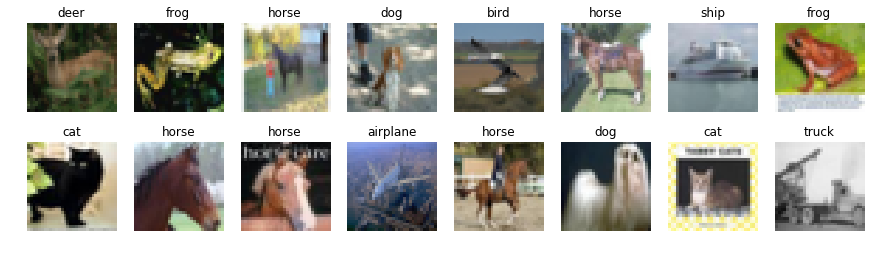

In [20]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(label_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(image_train[random_index, :])
        ax.set_title(cifar10_classes[label_train[random_index, 0]])
plt.show()

In [21]:
#Prepare data
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# normalize inputs
x_train = image_train / 255 - 0.5
x_test = image_test / 255 - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train = to_categorical(label_train)
y_test = to_categorical(label_test)

In [22]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

In [23]:
print("Train samples:", x_train.shape, y_train.shape)
print("Valid samples:", x_val.shape, y_val.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (40000, 32, 32, 3) (40000, 10)
Valid samples: (10000, 32, 32, 3) (10000, 10)
Test samples: (10000, 32, 32, 3) (10000, 10)


In [24]:
#Build model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
import keras

In [25]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    
    # one way of defining the model
    model = Sequential()

    model.add(Conv2D(16, 3, padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, 3, padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, 3, padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, 3, padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))

    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))
        
    return model

In [26]:
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [27]:
#Training
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 128

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", keras.backend.get_value(model.optimizer.lr))

In [28]:
model_filename = 'cifar-10.h5'
# fit model
model.fit_generator(datagen.flow(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True)],
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=1,
    workers=4
)

Epoch 1/128
Learning rate: 0.005
1250/1250 [==============================] - 241s 193ms/step - loss: 1.5323 - acc: 0.4428 - val_loss: 1.1477 - val_acc: 0.5839
Epoch 2/128
Learning rate: 0.0045
 467/1250 [==========>...................] - ETA: 2:24 - loss: 1.2432 - acc: 0.5503

KeyboardInterrupt: 

In [42]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

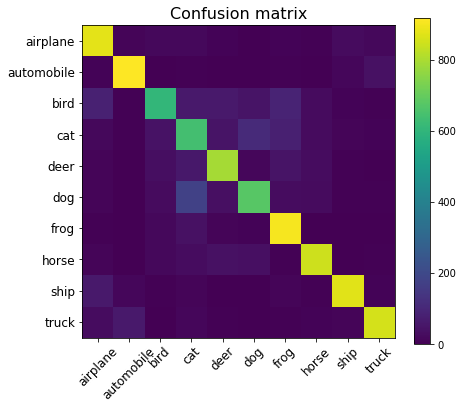

Test accuracy: 0.7994


In [43]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(label_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(label_test, y_pred_test_classes))